#Clasificador Blood Mnist en alta resolución

# Load a dataset of MedMNIST

version 0.6  enero 2024

Mariano Rivera


**MedMnist Dataset:** Daniel S. Kermany, Michael Goldbaum, et al., "Identifying medical diagnoses and treatable diseases by image-based deep learning," Cell, vol. 172, no. 5, pp. 1122 – 1131.e9, 2018.

# Seguimos este procedimiento para descargar datos

In [ ]:
!pip install -q medmnist

In [ ]:
import numpy as np
import os
import io
import imageio
import medmnist
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import keras

medmnist.INFO.keys()

dict_keys(['pathmnist', 'chestmnist', 'dermamnist', 'octmnist', 'pneumoniamnist', 'retinamnist', 'breastmnist', 'bloodmnist', 'tissuemnist', 'organamnist', 'organcmnist', 'organsmnist', 'organmnist3d', 'nodulemnist3d', 'adrenalmnist3d', 'fracturemnist3d', 'vesselmnist3d', 'synapsemnist3d'])

In [ ]:
# Get the metadata of the dataset
DATASET_NAME = list(medmnist.INFO.keys())[7]   # bloodmnis indice 7
data_info    = medmnist.INFO[DATASET_NAME]
name_labels  = data_info['label']

NUM_CLASSES = len(name_labels.keys())
IMAGE_SIZE  = "224"
N_CHANNELS  = data_info['n_channels']

def my_to_categorical(val, num_classes):
    I = np.eye(num_classes)
    return I[val]

num_classes = len(data_info['label'])

In [ ]:
def download_and_prepare_dataset(data_info, num_classes, image_size):
    url_key = "url_" + str(image_size) if image_size != "" else "url"
    md5_key = "MD5_" + str(image_size) if image_size != "" else "MD5"

    data_path = keras.utils.get_file(
        origin=data_info[url_key],
        md5_hash=data_info[md5_key]
    )

    with np.load(data_path) as data:
        train_images = np.expand_dims(data["train_images"], axis=-1)
        val_images   = np.expand_dims(data["val_images"],   axis=-1)
        test_images  = np.expand_dims(data["test_images"],  axis=-1)

        train_labels = my_to_categorical(data["train_labels"].flatten(), num_classes)
        val_labels   = my_to_categorical(data["val_labels"].flatten(),   num_classes)
        test_labels  = my_to_categorical(data["test_labels"].flatten(),  num_classes)

    return ( (train_images, train_labels),
             (val_images,   val_labels),
             (test_images,  test_labels) )


prepared_dataset = download_and_prepare_dataset(data_info, num_classes, IMAGE_SIZE) #hubo que agregar a num_clases como parámetro

In [ ]:
# Get the dataset
#prepared_dataset = download_and_prepare_dataset(data_info, IMAGE_SIZE)

(train_images, train_labels) = prepared_dataset[0]
(val_images,   val_labels)   = prepared_dataset[1]
(test_images,  test_labels)  = prepared_dataset[2]

In [ ]:
print("Train dataset :      ", train_images.shape, train_labels.shape)
print("Validation dataset : ", val_images.shape,   val_labels.shape)
print("Test dataset :       ", test_images.shape,  test_labels.shape)

num_train =  train_images.shape[0]
num_val   =  val_images.shape[0]

Train dataset :       (11959, 224, 224, 3, 1) (11959, 8)
Validation dataset :  (1712, 224, 224, 3, 1) (1712, 8)
Test dataset :        (3421, 224, 224, 3, 1) (3421, 8)


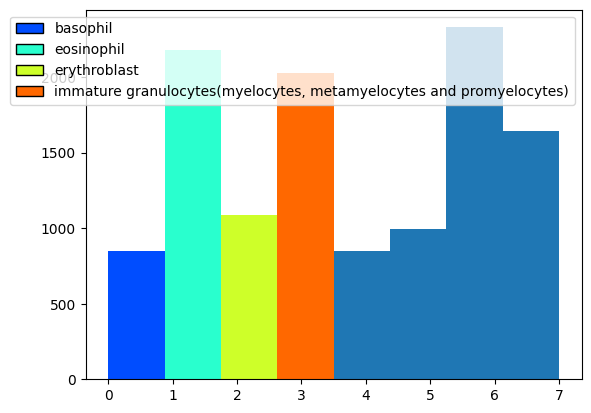

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

N, bins, patches = plt.hist(np.argmax(train_labels, axis=1),bins=NUM_CLASSES, ec="k" )

cmap =  plt.get_cmap('jet')
colors = cmap(0.2*np.array([1,2,3,4]))
for i in range(4):
    patches[i].set_facecolor(colors[i])

handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in colors]
labels= list(name_labels.values())
plt.legend(handles, labels)

In [ ]:
INPUT_SHAPE  = train_images.shape[1:]
INPUT_SHAPE

(224, 224, 3, 1)

In [ ]:
train_labels.shape

(11959, 8)

In [ ]:
first_idx=[]
for i in range(NUM_CLASSES):
    first_idx.append(np.where(train_labels[:,i]!=0)[0][1])

first_idx

[np.int64(38),
 np.int64(11),
 np.int64(7),
 np.int64(15),
 np.int64(37),
 np.int64(23),
 np.int64(3),
 np.int64(4)]

In [ ]:
train_images = np.squeeze(train_images, axis=-1)
val_images   = np.squeeze(val_images,   axis=-1)
test_images  = np.squeeze(test_images,  axis=-1)

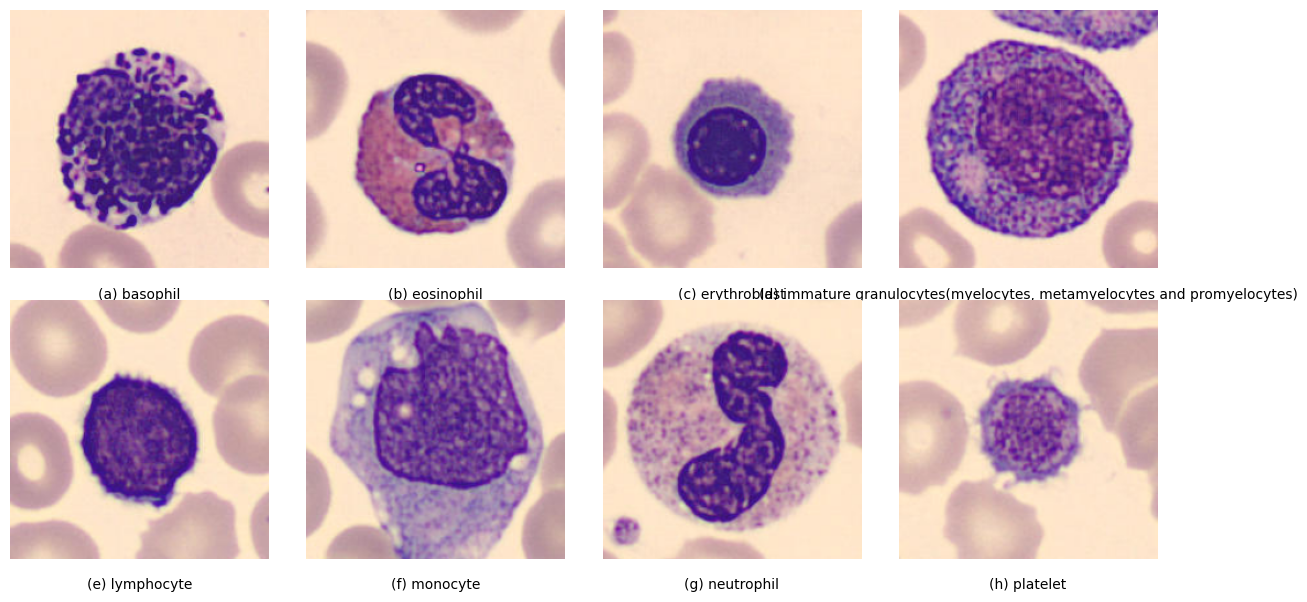

In [ ]:
#modificación del código para generalización
#ahora imprime una imágen ejemplo de todas las clases sin importar el dataset
#(antes solo 4 para el octmnist)

plt.figure(figsize=(12, 6))

for i in range(NUM_CLASSES):
    plt.subplot(2, 4, i+1)
    idx = first_idx[i]
    plt.imshow(train_images[idx])
    plt.axis('off')
    plt.title(f"({chr(97+i)}) {name_labels[str(i)]}", y=-0.15, fontsize=10)

plt.tight_layout()
plt.show()

Se trata de imágenes de células sanguíneas, con un total de 8 clases para clasificar

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="1";

import keras
keras.__version__

'3.8.0'

Usamos una red preentrenada VGG16

In [ ]:
from keras.applications import VGG16

vgg16 = VGG16(weights='imagenet',
                  include_top=True,
                  input_shape=(224, 224, 3))

In [ ]:
import numpy as np
from tqdm import tqdm
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Crear generador con preprocesamiento de VGG16
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
batch_size = 32

# Cargar VGG16 sin la parte densa (solo convolucional)
conv_base = VGG16(weights='imagenet',
                  include_top=False,         # quitamos la capa densa final
                  input_shape=(224, 224, 3))  # tu tamaño de imagen

def extract_features_from_array(images, labels, sample_count):
    '''
    Extrae características con la VGG16 desde arrays ya cargados.
    '''
    # features tendrán shape (N, 7, 7, 512) para VGG16 con input 224x224
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels_out = np.zeros(shape=(sample_count,))

    # Generador
    generator = datagen.flow(images, labels, batch_size=batch_size, shuffle=False)

    i = 0
    with tqdm(total=int(np.ceil(sample_count / batch_size))) as pbar:
        for inputs_batch, labels_batch in generator:
            features_batch = conv_base.predict(inputs_batch)
            features[i * batch_size : (i + 1) * batch_size] = features_batch
            labels_out[i * batch_size : (i + 1) * batch_size] = np.argmax(labels_batch, axis=1)
            i += 1
            pbar.update(1)
            if i * batch_size >= sample_count:
                break

    return features, labels_out

In [ ]:
"""
train_features, train_labels_feat = extract_features_from_array(train_images, train_labels, sample_count=len(train_images))
val_features,   val_labels_feat   = extract_features_from_array(val_images, val_labels,     sample_count=len(val_images))
test_features,  test_labels_feat  = extract_features_from_array(test_images, test_labels,   sample_count=len(test_images))
"""

num_samples = 1000  # número manejable
idx = np.random.choice(len(train_images), num_samples, replace=False)

train_images_sample = train_images[idx]
train_labels_sample = train_labels[idx]

Se tuvo que reducir la carga considerablemente porlos recurso limitados de google colab sacrificando la presición. Dado que tomamos las imágenes de 224x224 el proceso de estracción de características se volvió algo pesado. se crasheaba la RAM de los recursos disponibles de colab


In [ ]:
train_features, train_labels_feat = extract_features_from_array(
    train_images_sample, train_labels_sample, sample_count=num_samples
)

  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step


  3%|▎         | 1/32 [00:15<08:06, 15.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step


  6%|▋         | 2/32 [00:31<08:00, 16.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step


  9%|▉         | 3/32 [00:48<07:47, 16.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step


 12%|█▎        | 4/32 [01:04<07:29, 16.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 16%|█▌        | 5/32 [01:19<07:05, 15.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 19%|█▉        | 6/32 [01:34<06:40, 15.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 22%|██▏       | 7/32 [01:54<07:07, 17.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 25%|██▌       | 8/32 [02:09<06:31, 16.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 28%|██▊       | 9/32 [02:29<06:45, 17.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 31%|███▏      | 10/32 [02:45<06:13, 16.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 34%|███▍      | 11/32 [03:00<05:43, 16.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 38%|███▊      | 12/32 [03:20<05:52, 17.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 41%|████      | 13/32 [03:35<05:20, 16.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 44%|████▍     | 14/32 [03:56<05:23, 17.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 47%|████▋     | 15/32 [04:17<05:18, 18.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step


 50%|█████     | 16/32 [04:37<05:08, 19.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 53%|█████▎    | 17/32 [04:58<04:54, 19.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 56%|█████▋    | 18/32 [05:18<04:38, 19.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 59%|█████▉    | 19/32 [05:39<04:21, 20.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 62%|██████▎   | 20/32 [05:53<03:41, 18.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 66%|██████▌   | 21/32 [06:08<03:10, 17.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 69%|██████▉   | 22/32 [06:28<03:02, 18.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 72%|███████▏  | 23/32 [06:43<02:33, 17.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 75%|███████▌  | 24/32 [06:57<02:10, 16.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 78%|███████▊  | 25/32 [07:18<02:02, 17.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 81%|████████▏ | 26/32 [07:32<01:39, 16.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 84%|████████▍ | 27/32 [07:53<01:29, 17.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 88%|████████▊ | 28/32 [08:13<01:14, 18.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 91%|█████████ | 29/32 [08:34<00:57, 19.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 94%|█████████▍| 30/32 [08:54<00:39, 19.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 97%|█████████▋| 31/32 [09:15<00:19, 19.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


100%|██████████| 32/32 [09:20<00:00, 17.51s/it]


In [ ]:
# Asegúrate de extraer las características para validación y prueba
validation_features, validation_labels = extract_features_from_array(val_images, val_labels, sample_count=len(val_images))
test_features, test_labels = extract_features_from_array(test_images, test_labels, sample_count=len(test_images))


  0%|          | 0/54 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


  2%|▏         | 1/54 [00:14<12:33, 14.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


  4%|▎         | 2/54 [00:34<15:32, 17.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


  6%|▌         | 3/54 [00:55<16:15, 19.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


  7%|▋         | 4/54 [01:15<16:24, 19.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


  9%|▉         | 5/54 [01:29<14:24, 17.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 11%|█         | 6/54 [01:43<13:08, 16.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 13%|█▎        | 7/54 [01:58<12:16, 15.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 15%|█▍        | 8/54 [02:12<11:40, 15.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 17%|█▋        | 9/54 [02:32<12:40, 16.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 19%|█▊        | 10/54 [02:53<13:12, 18.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 20%|██        | 11/54 [03:13<13:27, 18.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 22%|██▏       | 12/54 [03:34<13:31, 19.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 24%|██▍       | 13/54 [03:48<12:06, 17.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 26%|██▌       | 14/54 [04:02<11:03, 16.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 28%|██▊       | 15/54 [04:23<11:33, 17.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 30%|██▉       | 16/54 [04:43<11:47, 18.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 31%|███▏      | 17/54 [04:58<10:42, 17.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 33%|███▎      | 18/54 [05:18<10:59, 18.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 35%|███▌      | 19/54 [05:39<11:04, 18.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 37%|███▋      | 20/54 [05:59<11:01, 19.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 39%|███▉      | 21/54 [06:20<10:52, 19.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 41%|████      | 22/54 [06:34<09:40, 18.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 43%|████▎     | 23/54 [06:55<09:45, 18.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 44%|████▍     | 24/54 [07:15<09:41, 19.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 46%|████▋     | 25/54 [07:36<09:32, 19.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 48%|████▊     | 26/54 [07:51<08:33, 18.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 50%|█████     | 27/54 [08:11<08:33, 19.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 52%|█████▏    | 28/54 [08:26<07:41, 17.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 54%|█████▎    | 29/54 [08:41<07:04, 16.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 56%|█████▌    | 30/54 [09:02<07:13, 18.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 57%|█████▋    | 31/54 [09:22<07:12, 18.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 59%|█████▉    | 32/54 [09:37<06:24, 17.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 61%|██████    | 33/54 [09:51<05:48, 16.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 63%|██████▎   | 34/54 [10:12<05:55, 17.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 65%|██████▍   | 35/54 [10:33<05:53, 18.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 67%|██████▋   | 36/54 [10:47<05:14, 17.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 69%|██████▊   | 37/54 [11:02<04:42, 16.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 70%|███████   | 38/54 [11:22<04:44, 17.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 72%|███████▏  | 39/54 [11:38<04:15, 17.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 74%|███████▍  | 40/54 [11:52<03:47, 16.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 76%|███████▌  | 41/54 [12:13<03:48, 17.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 78%|███████▊  | 42/54 [12:33<03:41, 18.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 80%|███████▉  | 43/54 [12:54<03:29, 19.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 81%|████████▏ | 44/54 [13:08<02:55, 17.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 83%|████████▎ | 45/54 [13:22<02:29, 16.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 85%|████████▌ | 46/54 [13:43<02:22, 17.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 87%|████████▋ | 47/54 [14:03<02:10, 18.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 89%|████████▉ | 48/54 [14:24<01:55, 19.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 91%|█████████ | 49/54 [14:44<01:37, 19.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 93%|█████████▎| 50/54 [15:05<01:19, 19.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 94%|█████████▍| 51/54 [15:25<01:00, 20.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 96%|█████████▋| 52/54 [15:46<00:40, 20.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 98%|█████████▊| 53/54 [16:06<00:20, 20.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


  1%|          | 1/107 [00:14<25:28, 14.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


  2%|▏         | 2/107 [00:28<25:00, 14.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


  3%|▎         | 3/107 [00:49<29:42, 17.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


  4%|▎         | 4/107 [01:09<31:43, 18.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


  5%|▍         | 5/107 [01:24<29:02, 17.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


  6%|▌         | 6/107 [01:44<30:44, 18.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


  7%|▋         | 7/107 [01:59<28:28, 17.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


  7%|▋         | 8/107 [02:20<30:00, 18.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


  8%|▊         | 9/107 [02:40<30:54, 18.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


  9%|▉         | 10/107 [02:54<28:14, 17.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 10%|█         | 11/107 [03:15<29:27, 18.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 11%|█         | 12/107 [03:35<30:10, 19.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 12%|█▏        | 13/107 [03:56<30:34, 19.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 13%|█▎        | 14/107 [04:17<30:43, 19.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 14%|█▍        | 15/107 [04:31<27:48, 18.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 15%|█▍        | 16/107 [04:51<28:36, 18.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 16%|█▌        | 17/107 [05:12<29:02, 19.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 17%|█▋        | 18/107 [05:32<29:14, 19.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 18%|█▊        | 19/107 [05:47<26:34, 18.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 19%|█▊        | 20/107 [06:01<24:36, 16.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 20%|█▉        | 21/107 [06:15<23:10, 16.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 21%|██        | 22/107 [06:31<22:31, 15.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 21%|██▏       | 23/107 [06:45<21:41, 15.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 22%|██▏       | 24/107 [07:06<23:31, 17.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 23%|██▎       | 25/107 [07:20<22:13, 16.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 24%|██▍       | 26/107 [07:36<21:34, 15.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 25%|██▌       | 27/107 [07:56<23:07, 17.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 26%|██▌       | 28/107 [08:17<24:06, 18.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 27%|██▋       | 29/107 [08:37<24:40, 18.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 28%|██▊       | 30/107 [08:58<24:57, 19.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 29%|██▉       | 31/107 [09:18<25:02, 19.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 30%|██▉       | 32/107 [09:39<25:00, 20.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 31%|███       | 33/107 [09:59<24:52, 20.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 32%|███▏      | 34/107 [10:20<24:40, 20.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 33%|███▎      | 35/107 [10:34<22:04, 18.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 34%|███▎      | 36/107 [10:54<22:31, 19.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 35%|███▍      | 37/107 [11:15<22:44, 19.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 36%|███▌      | 38/107 [11:36<22:47, 19.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 36%|███▋      | 39/107 [11:56<22:42, 20.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 37%|███▋      | 40/107 [12:17<22:32, 20.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 38%|███▊      | 41/107 [12:37<22:20, 20.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 39%|███▉      | 42/107 [12:58<22:04, 20.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 40%|████      | 43/107 [13:12<19:42, 18.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 41%|████      | 44/107 [13:32<20:02, 19.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 42%|████▏     | 45/107 [13:46<18:10, 17.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 43%|████▎     | 46/107 [14:01<16:51, 16.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 44%|████▍     | 47/107 [14:21<17:46, 17.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 45%|████▍     | 48/107 [14:36<16:41, 16.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 46%|████▌     | 49/107 [14:51<15:37, 16.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 47%|████▋     | 50/107 [15:11<16:35, 17.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 48%|████▊     | 51/107 [15:32<17:10, 18.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 49%|████▊     | 52/107 [15:46<15:44, 17.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 50%|████▉     | 53/107 [16:00<14:41, 16.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 50%|█████     | 54/107 [16:15<13:53, 15.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 51%|█████▏    | 55/107 [16:29<13:23, 15.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 52%|█████▏    | 56/107 [16:50<14:26, 16.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 53%|█████▎    | 57/107 [17:11<15:02, 18.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 54%|█████▍    | 58/107 [17:31<15:21, 18.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 55%|█████▌    | 59/107 [17:52<15:28, 19.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 56%|█████▌    | 60/107 [18:12<15:25, 19.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 57%|█████▋    | 61/107 [18:27<13:54, 18.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 58%|█████▊    | 62/107 [18:41<12:42, 16.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 59%|█████▉    | 63/107 [18:55<11:46, 16.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 60%|█████▉    | 64/107 [19:15<12:28, 17.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 61%|██████    | 65/107 [19:36<12:50, 18.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 62%|██████▏   | 66/107 [19:50<11:40, 17.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 63%|██████▎   | 67/107 [20:04<10:48, 16.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 64%|██████▎   | 68/107 [20:25<11:23, 17.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 64%|██████▍   | 69/107 [20:40<10:34, 16.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 65%|██████▌   | 70/107 [20:54<09:46, 15.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 66%|██████▋   | 71/107 [21:14<10:21, 17.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 67%|██████▋   | 72/107 [21:35<10:38, 18.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 68%|██████▊   | 73/107 [21:55<10:43, 18.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 69%|██████▉   | 74/107 [22:16<10:40, 19.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 70%|███████   | 75/107 [22:30<09:36, 18.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 71%|███████   | 76/107 [22:45<08:43, 16.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 72%|███████▏  | 77/107 [22:59<08:00, 16.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 73%|███████▎  | 78/107 [23:19<08:23, 17.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 74%|███████▍  | 79/107 [23:40<08:32, 18.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 75%|███████▍  | 80/107 [24:00<08:32, 18.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 76%|███████▌  | 81/107 [24:14<07:35, 17.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 77%|███████▋  | 82/107 [24:35<07:40, 18.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 78%|███████▊  | 83/107 [24:55<07:37, 19.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 79%|███████▊  | 84/107 [25:09<06:43, 17.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 79%|███████▉  | 85/107 [25:23<06:02, 16.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 80%|████████  | 86/107 [25:44<06:11, 17.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 81%|████████▏ | 87/107 [25:58<05:31, 16.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 82%|████████▏ | 88/107 [26:18<05:37, 17.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 83%|████████▎ | 89/107 [26:39<05:34, 18.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 84%|████████▍ | 90/107 [27:00<05:26, 19.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 85%|████████▌ | 91/107 [27:20<05:13, 19.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 86%|████████▌ | 92/107 [27:41<04:58, 19.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 87%|████████▋ | 93/107 [28:01<04:41, 20.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 88%|████████▊ | 94/107 [28:15<03:57, 18.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 89%|████████▉ | 95/107 [28:30<03:25, 17.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 90%|████████▉ | 96/107 [28:50<03:19, 18.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 91%|█████████ | 97/107 [29:04<02:48, 16.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 92%|█████████▏| 98/107 [29:25<02:41, 17.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 93%|█████████▎| 99/107 [29:45<02:30, 18.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 93%|█████████▎| 100/107 [29:59<02:01, 17.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 94%|█████████▍| 101/107 [30:13<01:38, 16.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 95%|█████████▌| 102/107 [30:34<01:28, 17.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 96%|█████████▋| 103/107 [30:55<01:14, 18.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 97%|█████████▋| 104/107 [31:09<00:51, 17.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 98%|█████████▊| 105/107 [31:30<00:36, 18.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


 99%|█████████▉| 106/107 [31:50<00:18, 18.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


100%|██████████| 107/107 [32:11<00:00, 18.05s/it]


In [ ]:
train_features_flat = np.reshape(train_features, (train_features.shape[0], 7 * 7 * 512))
val_features_flat = np.reshape(validation_features, (validation_features.shape[0], 7 * 7 * 512))
test_features_flat  = np.reshape(test_features,  (test_features.shape[0], 7 * 7 * 512))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Construir el modelo denso
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=7*7*512))  # Capa densa con 512 neuronas
model.add(Dropout(0.5))  # Regularización para evitar sobreajuste
model.add(Dense(256, activation='relu'))  # Capa densa con 256 neuronas
model.add(Dense(8, activation='softmax'))  # Capa de salida con 8 clases

# Compilación del modelo
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Resumen del modelo
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,978,952 (49.51 MB)

 Trainable params: 12,978,952 (49.51 MB)

 Non-trainable params: 0 (0.00 B)

Procesamos un poco más los datos antes del entrenamiento, convertir a one hot nevcesario para la categorical crossentropy

In [ ]:
#entrenamiento

from tensorflow.keras.utils import to_categorical

# Convierte las etiquetas de entrenamiento y validación a formato one-hot
train_labels_one_hot = to_categorical(train_labels, num_classes=8)
val_labels_one_hot = to_categorical(val_labels, num_classes=8)
test_labels_one_hot = to_categorical(test_labels, num_classes=8)

# Entrenamiento del modelo
history = model.fit(train_features_flat, train_labels_one_hot,
                    epochs=30,
                    batch_size=20,
                    validation_data=(val_features_flat, val_labels_one_hot),
                    verbose=2)

Epoch 1/30
50/50 - 10s - 200ms/step - accuracy: 0.9380 - loss: 0.1860 - val_accuracy: 0.1297 - val_loss: 3.7701
Epoch 2/30
50/50 - 10s - 203ms/step - accuracy: 0.9350 - loss: 0.1833 - val_accuracy: 0.1186 - val_loss: 3.8884
Epoch 3/30
50/50 - 9s - 180ms/step - accuracy: 0.9530 - loss: 0.1340 - val_accuracy: 0.1186 - val_loss: 4.0926
Epoch 4/30
50/50 - 10s - 192ms/step - accuracy: 0.9390 - loss: 0.1952 - val_accuracy: 0.1034 - val_loss: 4.4662
Epoch 5/30
50/50 - 10s - 201ms/step - accuracy: 0.9390 - loss: 0.1631 - val_accuracy: 0.1192 - val_loss: 4.0755
Epoch 6/30
50/50 - 10s - 209ms/step - accuracy: 0.9380 - loss: 0.1810 - val_accuracy: 0.1110 - val_loss: 4.1684
Epoch 7/30
50/50 - 10s - 203ms/step - accuracy: 0.9490 - loss: 0.1708 - val_accuracy: 0.1116 - val_loss: 5.0922
Epoch 8/30
50/50 - 9s - 183ms/step - accuracy: 0.9280 - loss: 0.2389 - val_accuracy: 0.1157 - val_loss: 4.8320
Epoch 9/30
50/50 - 11s - 213ms/step - accuracy: 0.9490 - loss: 0.1362 - val_accuracy: 0.1151 - val_loss: 5

Revisamos las dimensiones para verificar que el entrenamiento estuvo correcto. Por temas de uso limitado de la memoria RAM y GPU de google colab solo lo hice con una muestra aleatoria de 1000, por ello las dimensiones. Sabiendo el procedimiento, otro día con más recursos extraigo las características y entreno el modelo con más imágenes.

In [ ]:
print("val_features_flat shape:", val_features_flat.shape)
print("val_labels_one_hot shape:", val_labels_one_hot.shape)
print("test_features_flat shape:", test_features_flat.shape)
print("test_labels_one_hot shape:", test_labels_one_hot.shape)

val_features_flat shape: (1712, 25088)
val_labels_one_hot shape: (1712, 8)
test_features_flat shape: (3421, 25088)
test_labels_one_hot shape: (3421, 8)


In [ ]:
test_loss, test_accuracy = model.evaluate(test_features_flat, test_labels_one_hot)
print("Test accuracy:", test_accuracy)

107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.1077 - loss: 5.4294
Test accuracy: 0.1107863187789917


El accuraccy es evidentemente bajo y se lo adjudico en primer lugar a que solo usé 1000(demasiado pequeño incluso menor que el conjunto de validación) imágenes como entrenamiento, en el entrenamiento no había problema pero sí en la extracción de características por la memoria RAM disponible. lo siguiente sería idear una manera de hacerlo con menos recursos como bajar dimensionalidad de imágenes y equilibrar bien la cantidad de datos de entrenamiento, prueba y validación